In [1]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install seaborn

In [3]:
!pip install scikit-learn

In [4]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
import os

# Settings
batch_size = 32
img_height = 224
img_width = 224

# Path to your dataset
data_dir = "Vegetable Images"

# Function to get class names from the directory
def get_class_names(data_dir):
    # Get absolute path
    absolute_path = os.path.abspath(data_dir)
    print(f"Checking directory: {absolute_path}")
    
    # Check if the directory exists
    if not os.path.exists(absolute_path):
        raise FileNotFoundError(f"Directory {absolute_path} does not exist.")
    
    # Return sorted list of class names
    return sorted([dir_name for dir_name in os.listdir(absolute_path) if os.path.isdir(os.path.join(absolute_path, dir_name))])

# Print detected class names
try:
    print("Detected class names:", get_class_names(data_dir))
except FileNotFoundError as e:
    print(e)


Checking directory: c:\Users\acerc\Documents\UAP\Vegetable Images
Detected class names: ['test', 'train', 'validation']


In [6]:
# Settings
batch_size = 32
img_height = 224
img_width = 224
data_dir = "Vegetable Images"

# Load Datasets
train_ds_raw = image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_raw = image_dataset_from_directory(
    os.path.join(data_dir, 'validation'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds_raw = image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Save class names
class_names = train_ds_raw.class_names
print("Detected class names:", class_names)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Detected class names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [7]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_raw.map(lambda x, y: (normalization_layer(x), y))

In [8]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
# Dataset preparation
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Base Model: EfficientNetB0
base_model = InceptionV3(input_shape=(img_height, img_width, 3),
                            include_top=False,
                            weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build Model
num_classes = len(class_names)  # Use saved class names
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping Callback
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=10,
    restore_best_weights=True
)

# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlystop_callback]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10
469/469 [==============================] - 602s 1s/step - loss: 0.7415 - accuracy: 0.7959 - val_loss: 0.1851 - val_accuracy: 0.9557
Epoch 2/10
469/469 [==============================] - 560s 1s/step - loss: 0.2240 - accuracy: 0.9401 - val_loss: 0.1095 - val_accuracy: 0.9710
Epoch 3/10
469/469 [==============================] - 557s 1s/step - loss: 0.1483 - accuracy: 0.9571 - val_loss: 0.0787 - val_accuracy: 0.9787
Epoch 4/10
469/469 [==============================] - 549s 1s/step - loss: 0.1063 - accuracy: 0.9703 - val_loss: 0.0603 - val_accuracy: 0.9840
Epoch 5/10
469/469 [==============================] - 553s 1s/step - loss: 0.0847 - accuracy: 0.9771 - val_loss: 0.0490 - val_accuracy: 0.9890
Epoch 6/10
469/469 [==============================] - 535s 1s/step - loss: 0.0652 - accuracy: 0.9820 - val_loss: 0.0417 - val_accuracy: 0.9900
Epoch 7/10
469/469 [==============================] - 534s 1s/step - loss: 0.0559 - accuracy: 0.9852 - val_loss: 0.0394 - val_accuracy: 0.9897

In [11]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on test dataset
y_true = []
y_pred = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    y_true.extend(label_batch.numpy())  # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get class names from training dataset
class_names = train_ds_raw.class_names

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


1/1 [==============================] - 2s 2s/step
Classification Report:
               precision    recall  f1-score   support

        Bean       0.99      0.99      0.99       200
Bitter_Gourd       0.99      0.98      0.99       200
Bottle_Gourd       0.99      0.99      0.99       200
     Brinjal       0.97      1.00      0.98       200
    Broccoli       0.99      0.98      0.99       200
     Cabbage       1.00      0.99      1.00       200
    Capsicum       0.99      0.99      0.99       200
      Carrot       0.99      1.00      1.00       200
 Cauliflower       0.98      0.99      0.99       200
    Cucumber       0.98      0.97      0.98       200
      Papaya       0.97      0.97      0.97       200
      Potato       1.00      0.98      0.99       200
     Pumpkin       1.00      0.99      0.99       200
      Radish       0.99      0.99      0.99       200
      Tomato       0.99      0.98      0.99       200

    accuracy                           0.99      3000
   mac

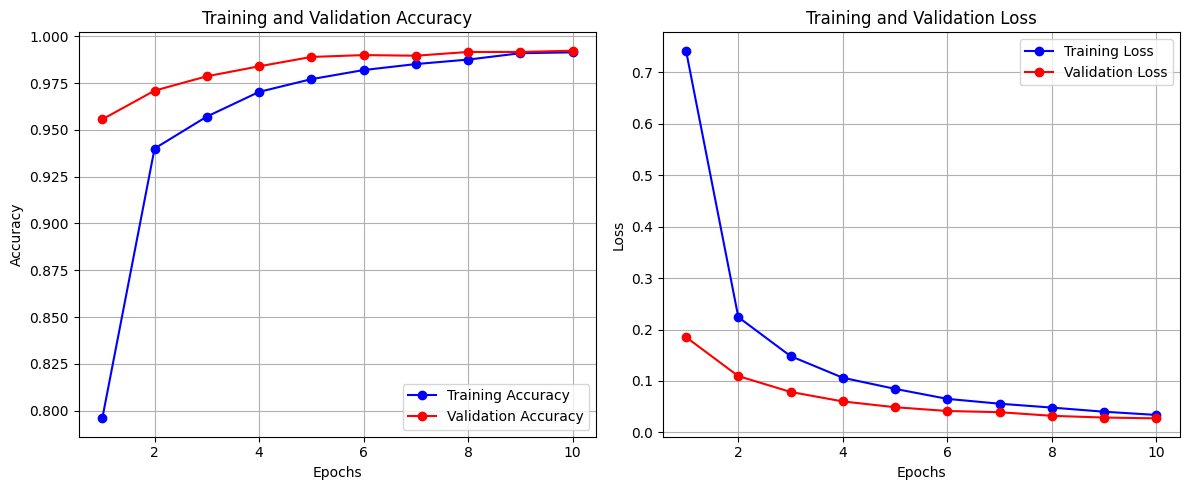

In [12]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


In [13]:
# # Save the model in SavedModel format
# model.save('saved_model/vegetable_classifier')

# Save the model in HDF5 format
model.save('vegetable_classifier_inception.h5')


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 22,066,991
Trainable params: 264,207
Non-trainable params: 21,802,784
____________________________________